In [1]:
from pathlib import Path
from typing import Callable

from pysr import PySRRegressor

# pysr before others, since it has to be before torch?
from jaxtyping import Float
import numpy as np
from zanj import ZANJ

from maze_dataset import MazeDatasetConfig
from maze_dataset.generation import LatticeMazeGenerators
from maze_dataset.benchmark.config_sweep import (
    SweepResult,
    full_percolation_analysis,
    dataset_success_fraction,
    plot_grouped,
)

[juliapkg] Found dependencies: f:\knc\maze-dataset\.venv\lib\site-packages\juliacall\juliapkg.json
[juliapkg] Found dependencies: f:\knc\maze-dataset\.venv\lib\site-packages\juliapkg\juliapkg.json
[juliapkg] Found dependencies: f:\knc\maze-dataset\.venv\lib\site-packages\pysr\juliapkg.json
[juliapkg] Locating Julia =1.10.0, ^1.10.3
[juliapkg] Installing Julia 1.11.3 using JuliaUp
[juliapkg] Using Julia 1.11.2 at C:\Users\mivan\AppData\Local\Microsoft\WindowsApps\julia.EXE
[juliapkg] Using Julia project at f:\KNC\maze-dataset\.venv\julia_env
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d"), Pkg.PackageSpec(name="SymbolicRegression", uuid="8254be44-1295-4e6a-a16d-46603ac705cb"), Pkg.PackageSpec(name="Serialization", uuid="9e88b42a-f829-5b0c-bbe9-9e923198166b")])
           julia> Pkg.resolve()
           julia> Pkg.precompile()
Det

In [2]:
# magic auto-reload
%load_ext autoreload
%autoreload

tqdm_allowed_kwargs = {'leave', 'bar_format', 'postfix', 'disable', 'unit_divisor', 'unit_scale', 'self', 'write_bytes', 'position', 'colour', 'lock_args', 'desc', 'delay', 'file', 'total', 'mininterval', 'initial', 'ascii', 'gui', 'maxinterval', 'dynamic_ncols', 'miniters', 'nrows', 'iterable', 'smoothing', 'ncols', 'unit'}
mapped_kwargs = {'total': 3, 'desc': 'Processing 3 items'}


Processing 3 items: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


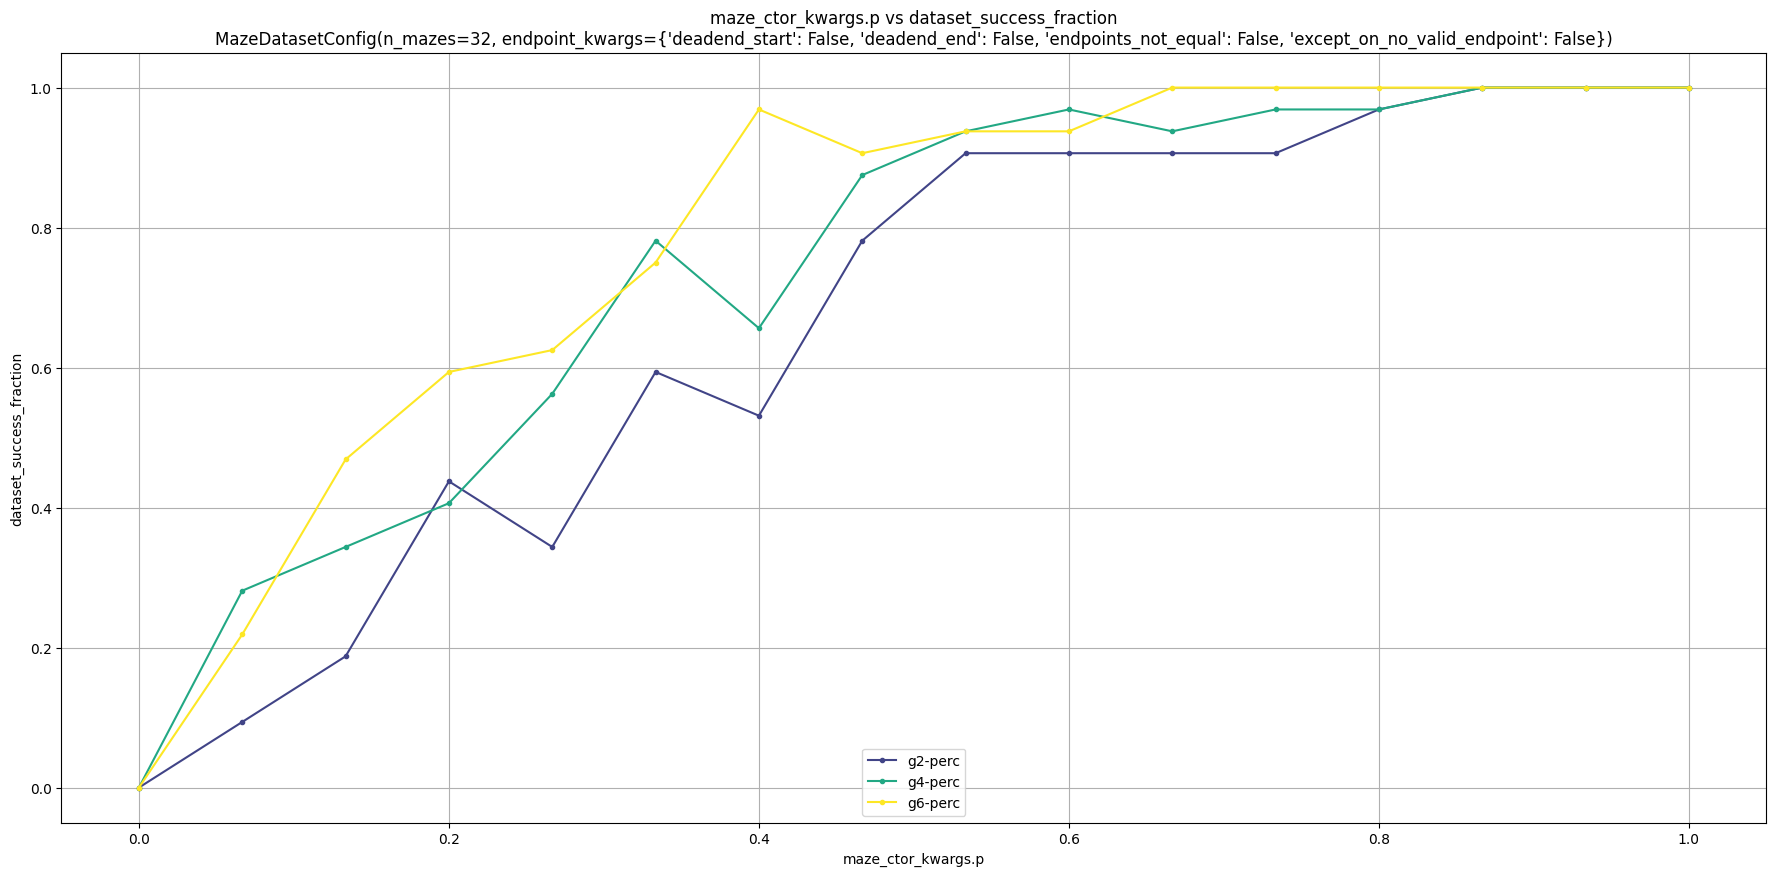

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [3]:
# Run the analysis
results: SweepResult = SweepResult.analyze(
    configs=[
        MazeDatasetConfig(
            name=f"g{grid_n}-perc",
            grid_n=grid_n,
            n_mazes=32,
            maze_ctor=LatticeMazeGenerators.gen_percolation,
            maze_ctor_kwargs=dict(),
            endpoint_kwargs=dict(
                deadend_start=False,
                deadend_end=False,
                endpoints_not_equal=False,
                except_on_no_valid_endpoint=False,
            ),
        )
        for grid_n in [2, 4, 6]
    ],
    param_values=np.linspace(0.0, 1.0, 16).tolist(),
    param_key="maze_ctor_kwargs.p",
    analyze_func=dataset_success_fraction,
    parallel=False,
)

# Plot results
results.plot(save_path=None, cfg_keys=["n_mazes", "endpoint_kwargs"])

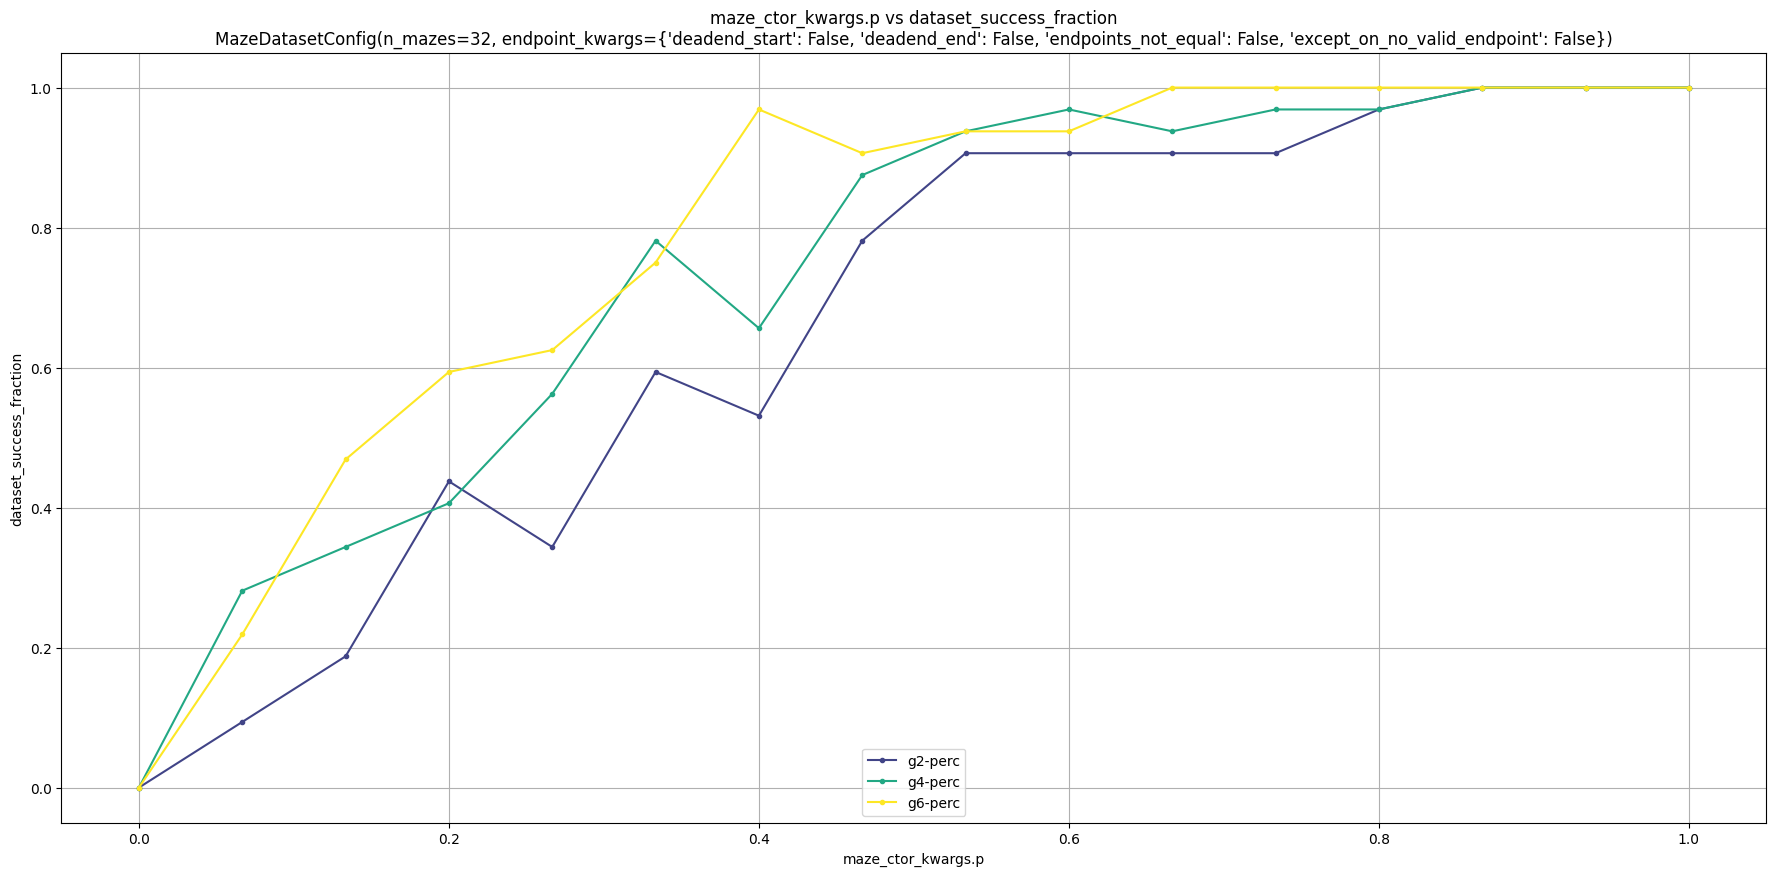

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [4]:
path = Path("../tests/_temp/dataset_frac_sweep/results_small.zanj")
results.save(path)
ZANJ().read(path).plot(cfg_keys=["n_mazes", "endpoint_kwargs"])

In [5]:
results_full: SweepResult = full_percolation_analysis(
    n_mazes=64,
    p_val_count=16,
    grid_sizes=[2, 4, 6],
    parallel=True,
)

tqdm_allowed_kwargs = {'leave', 'bar_format', 'postfix', 'disable', 'unit_divisor', 'unit_scale', 'self', 'write_bytes', 'position', 'colour', 'lock_args', 'desc', 'delay', 'file', 'total', 'mininterval', 'initial', 'ascii', 'gui', 'maxinterval', 'dynamic_ncols', 'miniters', 'nrows', 'iterable', 'smoothing', 'ncols', 'unit'}
mapped_kwargs = {'total': 18, 'desc': 'Processing 18 items'}


Processing 18 items: 100%|██████████| 18/18 [00:24<00:00,  1.36s/it]


Saving results to ../docs/benchmarks/percolation_fractions/result-n64-c18-p16.zanj


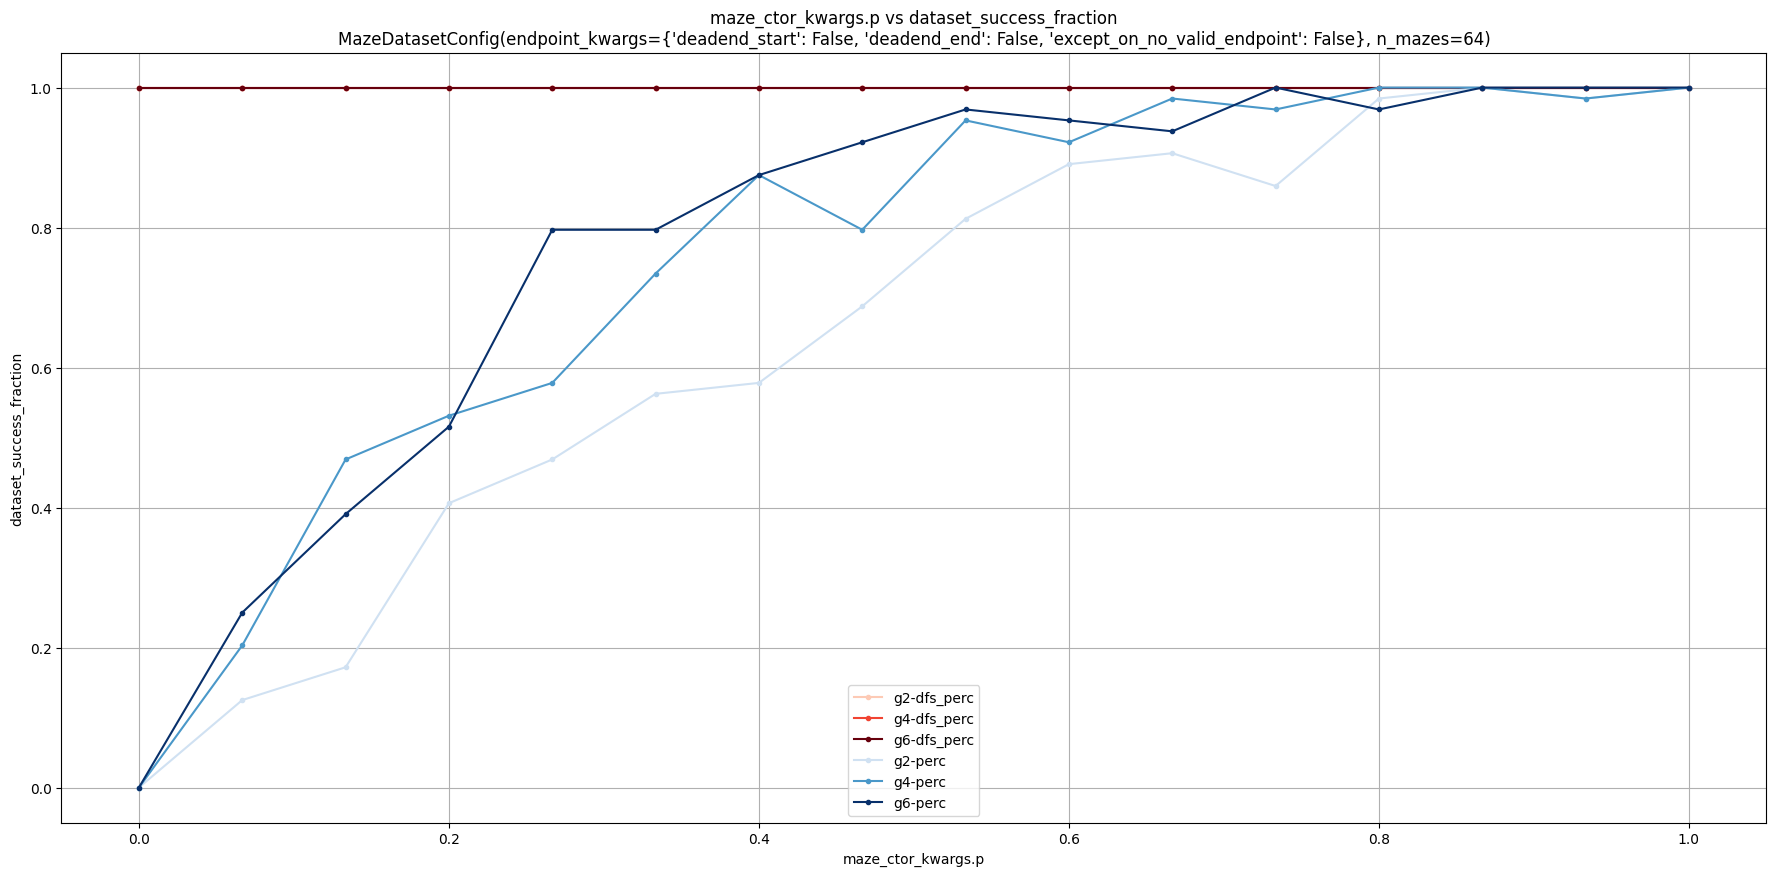

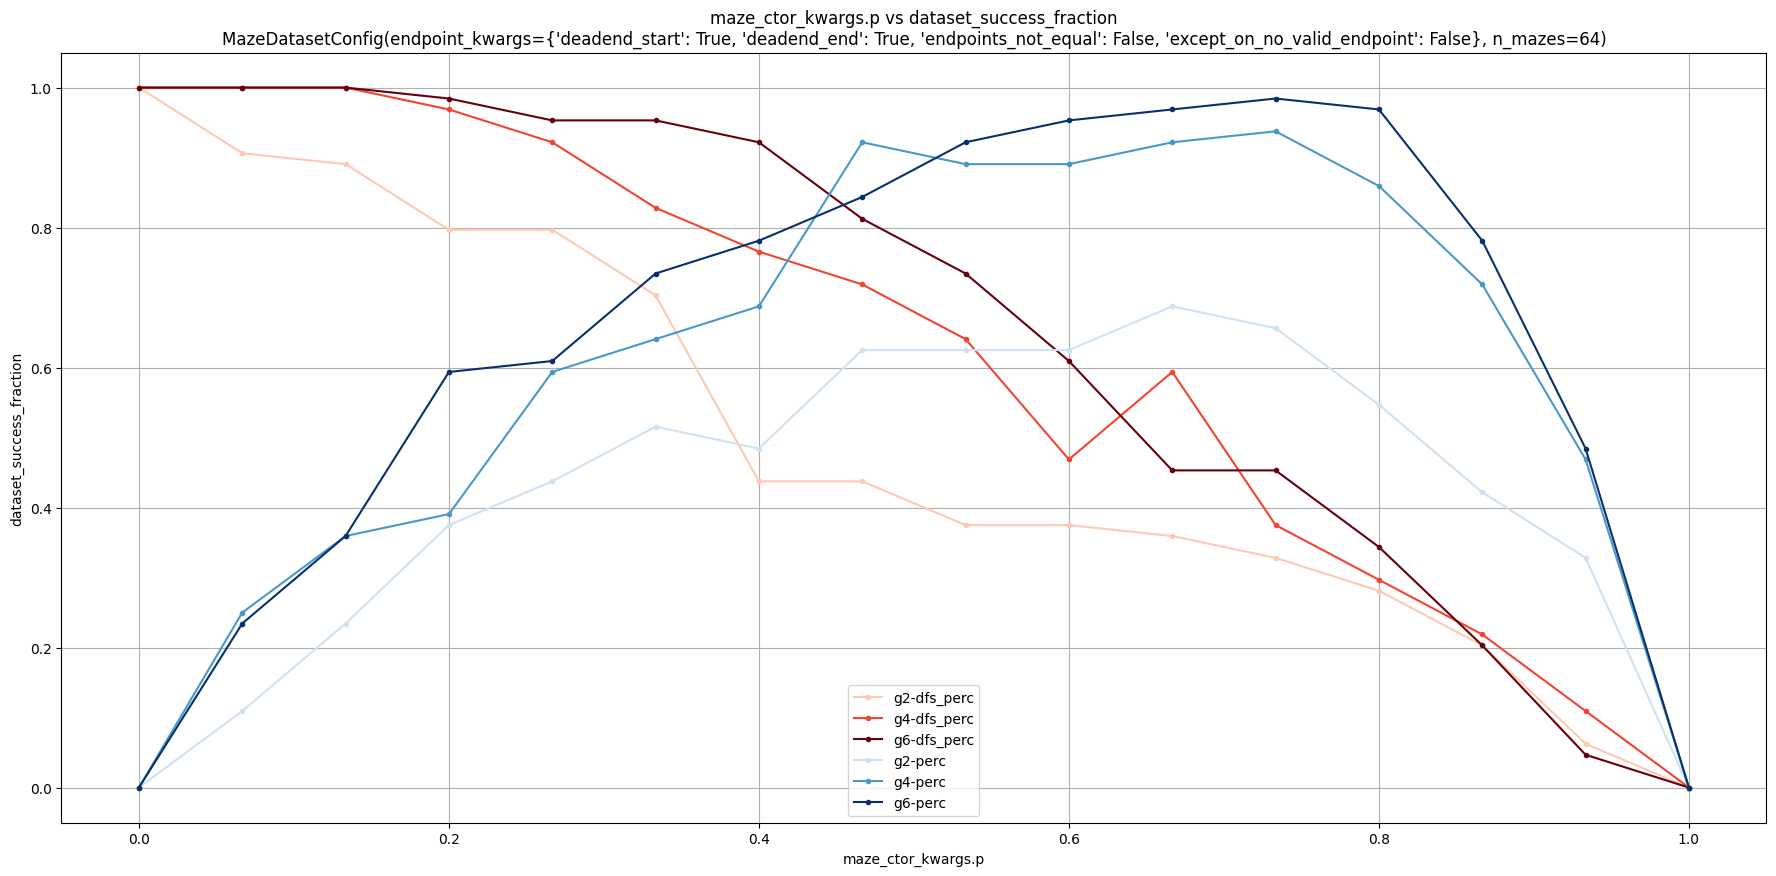

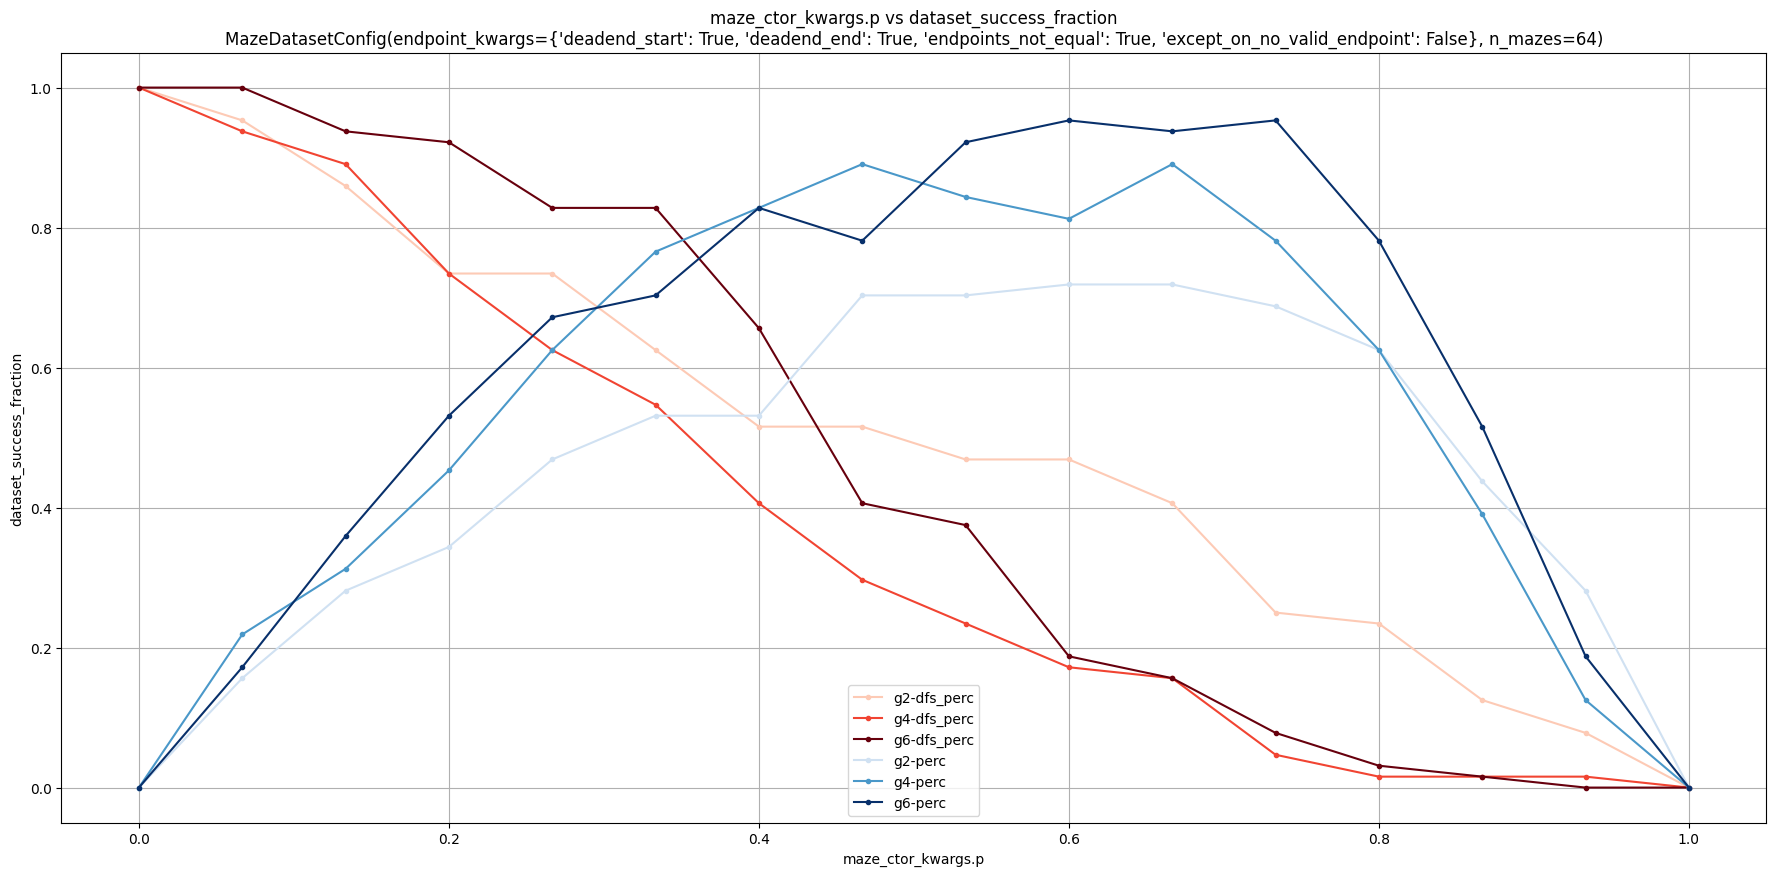

In [6]:
plot_grouped(results_full)

In [ ]:
def extract_training_data(
    sweep_result: SweepResult,
) -> tuple[Float[np.ndarray, "num_rows 5"], Float[np.ndarray, " num_rows"]]:
    """Extract data (X, y) from a SweepResult.

    # Parameters:
     - `sweep_result : SweepResult`
        The sweep result holding configs and success arrays.

    # Returns:
     - `X : Float[np.ndarray, "num_rows 5"]`
        Stacked [p, grid_n, deadends, endpoints_not_equal, generator_func] for each config & param-value
     - `y : Float[np.ndarray, "num_rows"]`
        The corresponding success rate
    """
    X_list = []
    y_list = []

    param_values = sweep_result.param_values  # e.g. [0.0, 0.1, ..., 1.0]

    for cfg in sweep_result.configs:
        # success_arr is an array of success rates for param_values
        success_arr = sweep_result.result_values[cfg.to_fname()]
        for i, p in enumerate(param_values):
            # Temporarily override p in the config's array representation:
            arr = cfg._to_ps_array().copy()
            arr[0] = p  # index 0 is 'p'
            X_list.append(arr)
            y_list.append(success_arr[i])

    X = np.array(X_list, dtype=np.float64)
    y = np.array(y_list, dtype=np.float64)
    return X, y


def fit_pysr_model(
    X: Float[np.ndarray, "num_rows 5"],
    y: Float[np.ndarray, " num_rows"],
    niterations: int = 200,
) -> PySRRegressor:
    """Train a PySR model on the array data.

    # Parameters:
     - `X : Float[np.ndarray, "num_rows 5"]`
        Feature matrix
     - `y : Float[np.ndarray, "num_rows"]`
        Success rates
     - `niterations : int`
        Number of PySR search iterations

    # Returns:
     - `PySRRegressor`
        The fitted model
    """
    model = PySRRegressor(
        niterations=niterations,
        # Adjust operators as needed
        unary_operators=["sin", "cos", "exp"],
        binary_operators=["+", "-", "*", "/"],
        # If you want advanced features, specify them here:
        # e.g. select_k_features=4, population_size=1000, etc.
        progress=True,
        model_selection="best",
    )
    model.fit(X, y)
    return model


def create_predict_config(model: PySRRegressor) -> Callable[[MazeDatasetConfig], float]:
    """Return a function that predicts success rate from a MazeDatasetConfig.

    # Parameters:
     - `model : PySRRegressor`
        Fitted model with at least one equation

    # Returns:
     - `Callable[[MazeDatasetConfig], float]`
        A callable taking a MazeDatasetConfig and returning a predicted success rate
    """
    # The "best" equation is a row from model.equations_ with an arrow in 'pick' column
    best_equation = model.get_best()  # -> dict with "lambda_format", etc.
    python_expr_str: str = best_equation["lambda_format"]
    # e.g. "lambda x0, x1, x2, x3, x4: 0.5 + (x0 * ...)"

    # Turn that string into a Python function:
    predict_fn = eval(python_expr_str)

    def predict_config(cfg: MazeDatasetConfig) -> float:
        arr = cfg.to_array()
        return float(predict_fn(*arr))  # pass the array as separate args

    return predict_config


def example_usage(sr: SweepResult) -> None:
    # Convert to arrays and fit
    X, y = extract_training_data(sr)
    model = fit_pysr_model(X, y, niterations=300)

    # Create a callable that predicts from MazeDatasetConfig
    predict_cfg = create_predict_config(model)

    # Example new config
    test_config = MazeDatasetConfig(
        name="some_test",
        grid_n=16,
        n_mazes=100,
        maze_ctor=LatticeMazeGenerators.gen_percolation,
        maze_ctor_kwargs={"p": 0.3},
        endpoint_kwargs={
            "deadend_start": True,
            "deadend_end": True,
            "endpoints_not_equal": True,
        },
    )
    predicted_rate = predict_cfg(test_config)
    print("Best PySR Equation:", model.get_best()["equation"])
    print("Predicted success rate for test_config:", predicted_rate)


example_usage(results_full)

AssertionError: maze_ctor_kwargs must have a 'p' (percolation value) key